In [1]:
# industry_code_predictor_pytorch.py (with TF-IDF save/load and StratifiedKFold)

import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pickle

matplotlib.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from scipy.sparse import hstack

# 1. Load and prepare dataset
path = "data_3.csv"
df = pd.read_csv(path)

text_col = "상호명"
target_col = "산업분류코드"
categorical_cols = ["관할세무서코드","개인법인구분", "과세유형코드", "기업규모", "시도명"]

columns_needed = [text_col, target_col] + categorical_cols + ["취급품목"]
df = df[columns_needed]

for col in categorical_cols:
    df[col] = df[col].fillna("Unknown")
df[text_col] = df[text_col].fillna("")
df['취급품목'] = df['취급품목'].fillna("")
df = df.dropna(subset=[target_col])

# Remove rare classes
y_counts = df[target_col].value_counts()
df = df[df[target_col].isin(y_counts[y_counts >= 2].index)]

# Label encoding
y_labels = df[target_col].astype(str)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)

# 통합 텍스트 (상호명 + 취급품목)
df['통합텍스트'] = df['상호명'] + ' ' + df['취급품목']

# TF-IDF 벡터 저장 및 재사용
vectorizer_path = "tfidf_vectorizer.pkl"
if os.path.exists(vectorizer_path):
    with open(vectorizer_path, "rb") as f:
        vectorizer = pickle.load(f)
    X_text = vectorizer.transform(df['통합텍스트'])
else:
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=3000)
    X_text = vectorizer.fit_transform(df['통합텍스트'])
    with open(vectorizer_path, "wb") as f:
        pickle.dump(vectorizer, f)

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
X_cat = encoder.fit_transform(df[categorical_cols])

X = hstack([X_text, X_cat]).astype(np.float32)
X_array = X.toarray()
y_array = np.array(y_encoded, dtype=np.int64)

# PyTorch Dataset
tensor_X = torch.tensor(X_array)
tensor_y = torch.tensor(y_array)
dataset = TensorDataset(tensor_X, tensor_y)

# Device (MPS > CUDA > CPU)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print(f"PyTorch 학습 디바이스: {device}")

# Model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_f1s = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_array, y_array)):
    print(f"\n---- Fold {fold + 1} ----")
    train_ds = Subset(dataset, train_idx)
    val_ds = Subset(dataset, val_idx)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)

    model = MLPClassifier(X_array.shape[1], len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_loss = float('inf')
    patience = 3
    trigger_times = 0

    for epoch in range(30):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"[Epoch {epoch+1}] Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping triggered.")
                break

    # Evaluation
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    fold_accuracies.append(acc)
    fold_f1s.append(f1)

    print(f"Fold {fold+1} Accuracy: {acc:.4f}, F1(Macro): {f1:.4f}")

    print(classification_report(label_encoder.inverse_transform(y_true), label_encoder.inverse_transform(y_pred)))

print("\n==== Cross Validation Results ====")
print(f"Avg Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Avg F1(Macro): {np.mean(fold_f1s):.4f}")

PyTorch 학습 디바이스: mps

---- Fold 1 ----
[Epoch 1] Train Loss: 60171.3783, Val Loss: 1.5637
[Epoch 2] Train Loss: 58919.9401, Val Loss: 1.5605
[Epoch 3] Train Loss: 58700.4072, Val Loss: 1.5611
[Epoch 4] Train Loss: 58584.1408, Val Loss: 1.5642
[Epoch 5] Train Loss: 58503.2783, Val Loss: 1.5636
Early stopping triggered.
Fold 1 Accuracy: 0.5061, F1(Macro): 0.1962
              precision    recall  f1-score   support

         C13       0.68      0.03      0.06      1394
         C14       0.51      0.08      0.14     19179
         C21       0.79      0.03      0.07      5373
         D35       0.00      0.00      0.00         5
         G45       0.58      0.05      0.10      6359
         G46       0.50      0.00      0.01      1421
         G47       0.48      0.62      0.54    189297
         H49       0.80      0.80      0.80      7598
         H50       0.00      0.00      0.00       185
         H51       1.00      0.06      0.11        18
         H52       0.69      0.13      0.2


[상위 중요 특성]
헤어: 1.0999
노래연습장: 1.0946
처갓집양념치킨: 1.0564
양평해장국: 1.0413
hair: 1.0362
옛날통닭: 1.0347
더벤티: 1.0296
마라탕: 1.0285
김밥나라: 1.0240
명륜진사갈비: 1.0143
맘스터치: 1.0143
노랑통닭: 0.9968
푸라닭: 0.9960
투썸플레이스: 0.9833
가마치통닭: 0.9768
크라운호프: 0.9715
칼국수: 0.9645
호식이두마리치킨: 0.9630
자담치킨: 0.9551
이삭토스트: 0.9418
역전할머니맥주: 0.9407
부어치킨: 0.9383
신전떡볶이: 0.9313
도미노피자: 0.9299
비비큐: 0.9283
써브웨이: 0.9277
짬뽕: 0.9260
파리바게뜨: 0.9185
삼겹살: 0.9167
본죽: 0.9161


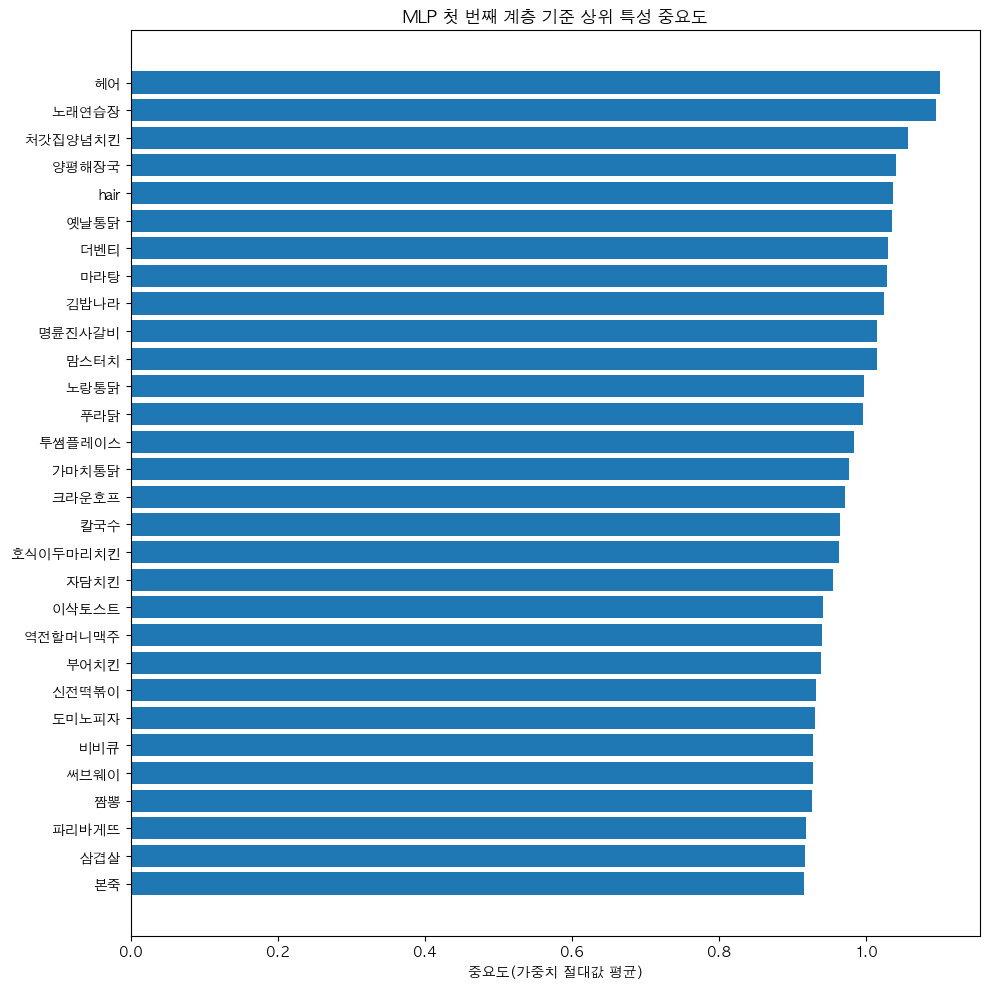

In [2]:
importances = None

# 특성 중요도 계산 (MLP는 직접적 중요도 제공하지 않으므로, 첫 번째 Linear 계층의 가중치 절대값 평균 사용)
if hasattr(model, 'model') and isinstance(model.model[0], nn.Linear):
    first_layer_weights = model.model[0].weight.detach().cpu().numpy()
    importances = np.mean(np.abs(first_layer_weights), axis=0)

    # 상위 30개 특성 출력
    topk = 30
    indices = np.argsort(importances)[::-1][:topk]
    feature_names = (
        list(vectorizer.get_feature_names_out()) +
        list(encoder.get_feature_names_out(categorical_cols))
    )
    print("\n[상위 중요 특성]")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    # 시각화
    plt.figure(figsize=(10, 10))
    plt.barh([feature_names[i] for i in indices[::-1]], importances[indices[::-1]])
    plt.xlabel("중요도(가중치 절대값 평균)")
    plt.title("MLP 첫 번째 계층 기준 상위 특성 중요도")
    plt.tight_layout()
    plt.show()
else:
    print("특성 중요도를 계산할 수 없습니다.")